In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/498_Dataset/kidneyData.csv',index_col=0)

In [ ]:
df.head()

,image_id,path,diag,target,Class
0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
class_distribution = df["Class"].value_counts()

In [ ]:
class_distribution

Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: Class, dtype: int64

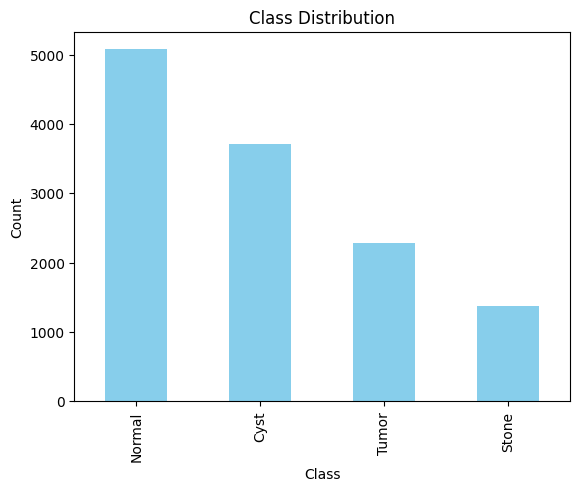

In [ ]:
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
traindatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1.0 / 255
)

# Define the image dimensions and batch size
image_size = (224, 224)
batch_size = 32

# Create data generators for train, validation, and test sets
train_generator = traindatagen.flow_from_directory(
    '/content/drive/MyDrive/498_Dataset/Train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = traindatagen.flow_from_directory(
    '/content/drive/MyDrive/498_Dataset/Train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/498_Dataset/Test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10306 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Found 1245 images belonging to 4 classes.


### ResNet50

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

model_resnet = Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
num_epochs = 15  # You can adjust the number of epochs

history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/15
323/323 [==============================] - 2709s 8s/step - loss: 1.2363 - accuracy: 0.4610 - val_loss: 1.2385 - val_accuracy: 0.4842
Epoch 2/15
323/323 [==============================] - 236s 732ms/step - loss: 1.1289 - accuracy: 0.5516 - val_loss: 1.1404 - val_accuracy: 0.5508
Epoch 3/15
323/323 [==============================] - 214s 662ms/step - loss: 1.0816 - accuracy: 0.5703 - val_loss: 1.1193 - val_accuracy: 0.5648
Epoch 4/15
323/323 [==============================] - 216s 667ms/step - loss: 1.0509 - accuracy: 0.5802 - val_loss: 1.0477 - val_accuracy: 0.5954
Epoch 5/15
323/323 [==============================] - 215s 667ms/step - loss: 1.0209 - accuracy: 0.5907 - val_loss: 1.1292 - val_accuracy: 0.5499
Epoch 6/15
323/323 [==============================] - 216s 669ms/step - loss: 1.0138 - accuracy: 0.5950 - val_loss: 1.0329 - val_accuracy: 0.5709
Epoch 7/15
323/323 [==============================] - 215s 667ms/step - loss: 0.9923 - accuracy: 0.5983 - val_loss: 1.0163 - v

In [ ]:
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 [==============================] - 286s 8s/step - loss: 0.6929 - accuracy: 0.7317
Test Accuracy: 73.17%


In [ ]:
model_resnet.save('/content/drive/My Drive/498models/resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


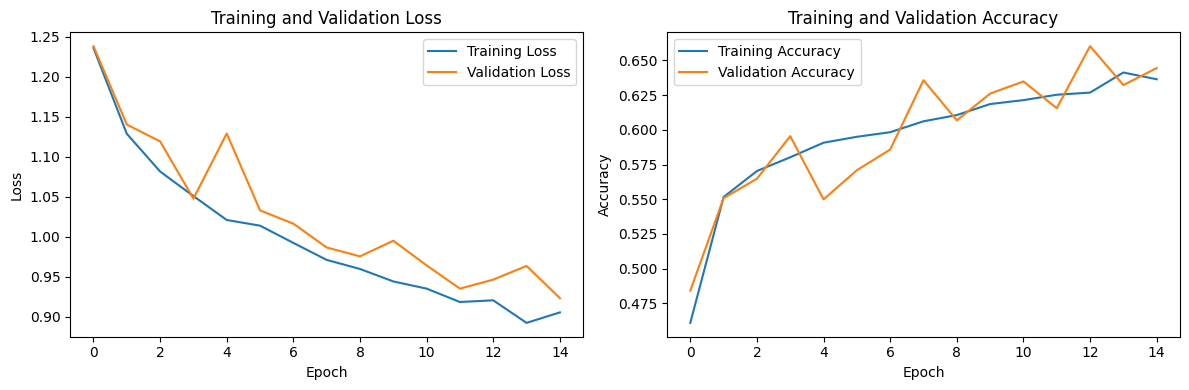

In [ ]:
# Access the training history
training_loss = history_resnet.history['loss']
validation_loss = history_resnet.history['val_loss']
training_accuracy = history_resnet.history['accuracy']
validation_accuracy = history_resnet.history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


### VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

model_vgg = Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
num_epochs = 25  # You can adjust the number of epochs

history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/25
323/323 [==============================] - 248s 749ms/step - loss: 1.0143 - accuracy: 0.5933 - val_loss: 0.9718 - val_accuracy: 0.6471
Epoch 2/25
323/323 [==============================] - 219s 679ms/step - loss: 0.7390 - accuracy: 0.7326 - val_loss: 0.8870 - val_accuracy: 0.6515
Epoch 3/25
323/323 [==============================] - 225s 697ms/step - loss: 0.6180 - accuracy: 0.7771 - val_loss: 0.8282 - val_accuracy: 0.6751
Epoch 4/25
323/323 [==============================] - 222s 687ms/step - loss: 0.5355 - accuracy: 0.8154 - val_loss: 0.7700 - val_accuracy: 0.6804
Epoch 5/25
323/323 [==============================] - 223s 689ms/step - loss: 0.4752 - accuracy: 0.8402 - val_loss: 0.7507 - val_accuracy: 0.6778
Epoch 6/25
323/323 [==============================] - 240s 744ms/step - loss: 0.4552 - accuracy: 0.8448 - val_loss: 0.8294 - val_accuracy: 0.6559
Epoch 7/25
323/323 [==============================] - 222s 688ms/step - loss: 0.4100 - accuracy: 0.8666 - val_loss: 0.7503 -

In [ ]:
model_vgg.save('/content/drive/My Drive/498models/vgg.h5')

In [ ]:
test_loss, test_accuracy = model_vgg.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 [==============================] - 11s 273ms/step - loss: 0.2202 - accuracy: 0.9357
Test Accuracy: 93.57%


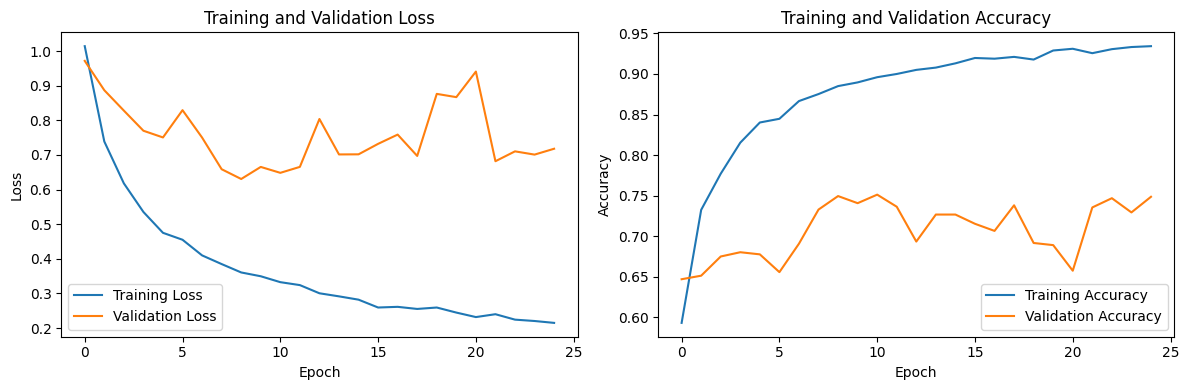

In [ ]:
# Access the training history
training_loss = history_vgg.history['loss']
validation_loss = history_vgg.history['val_loss']
training_accuracy = history_vgg.history['accuracy']
validation_accuracy = history_vgg.history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


### MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

model_MobileNetV2 = Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model_MobileNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
num_epochs = 15  # You can adjust the number of epochs

history_MobileNetV2 = model_MobileNetV2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/15
323/323 [==============================] - 8144s 25s/step - loss: 0.6771 - accuracy: 0.7512 - val_loss: 0.9316 - val_accuracy: 0.5797
Epoch 2/15
323/323 [==============================] - 215s 666ms/step - loss: 0.4314 - accuracy: 0.8598 - val_loss: 0.6593 - val_accuracy: 0.7215
Epoch 3/15
323/323 [==============================] - 214s 663ms/step - loss: 0.3547 - accuracy: 0.8827 - val_loss: 0.7623 - val_accuracy: 0.7023
Epoch 4/15
323/323 [==============================] - 215s 666ms/step - loss: 0.2975 - accuracy: 0.9048 - val_loss: 0.8268 - val_accuracy: 0.6602
Epoch 5/15
323/323 [==============================] - 212s 656ms/step - loss: 0.2632 - accuracy: 0.9167 - val_loss: 0.7660 - val_accuracy: 0.7154
Epoch 6/15
323/323 [==============================] - 215s 665ms/step - loss: 0.2446 - accuracy: 0.9257 - val_loss: 0.9042 - val_accuracy: 0.6646
Epoch 7/15
323/323 [==============================] - 210s 650ms/step - loss: 0.2377 - accuracy: 0.9262 - val_loss: 0.7883 - 

In [ ]:
model_MobileNetV2.save('/content/drive/My Drive/498models/MobileNetV2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy = model_MobileNetV2.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 [==============================] - 971s 26s/step - loss: 0.1870 - accuracy: 0.9558
Test Accuracy: 95.58%


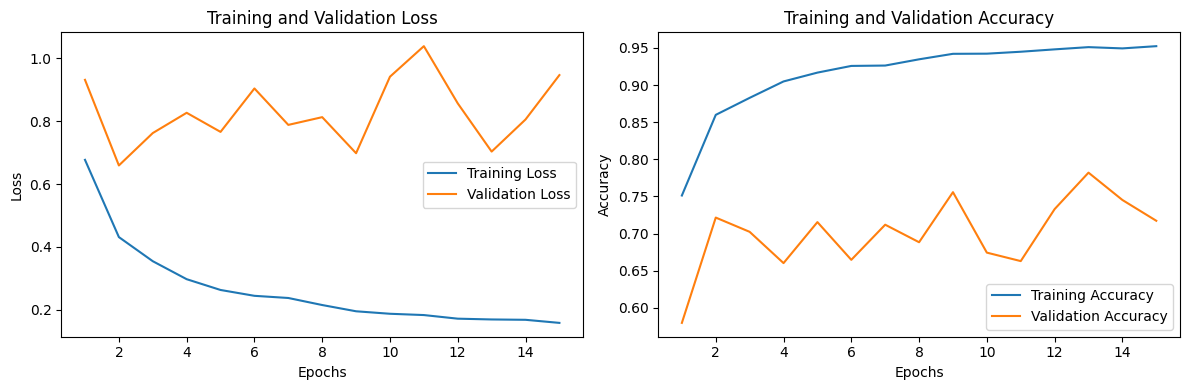

In [ ]:
history = {
    'loss': [0.6771, 0.4314, 0.3547, 0.2975, 0.2632, 0.2446, 0.2377, 0.2153, 0.1954, 0.1875, 0.1834, 0.1719, 0.1694, 0.1683, 0.1585],
    'accuracy': [0.7512, 0.8598, 0.8827, 0.9048, 0.9167, 0.9257, 0.9262, 0.9346, 0.9420, 0.9422, 0.9448, 0.9480, 0.9510, 0.9493, 0.9523],
    'val_loss': [0.9316, 0.6593, 0.7623, 0.8268, 0.7660, 0.9042, 0.7883, 0.8129, 0.6982, 0.9416, 1.0387, 0.8568, 0.7034, 0.8055, 0.9467],
    'val_accuracy': [0.5797, 0.7215, 0.7023, 0.6602, 0.7154, 0.6646, 0.7119, 0.6883, 0.7557, 0.6743, 0.6629, 0.7329, 0.7820, 0.7452, 0.7172]
}

epochs = range(1, len(history['loss']) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

model_InceptionV3 = Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
num_epochs = 25  # You can adjust the number of epochs

history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/25
323/323 [==============================] - 4938s 15s/step - loss: 0.8890 - accuracy: 0.6544 - val_loss: 1.0400 - val_accuracy: 0.5709
Epoch 2/25
323/323 [==============================] - 237s 733ms/step - loss: 0.6445 - accuracy: 0.7654 - val_loss: 0.9332 - val_accuracy: 0.6051
Epoch 3/25
323/323 [==============================] - 236s 730ms/step - loss: 0.5343 - accuracy: 0.8128 - val_loss: 0.7239 - val_accuracy: 0.7040
Epoch 4/25
323/323 [==============================] - 218s 675ms/step - loss: 0.4967 - accuracy: 0.8275 - val_loss: 0.7853 - val_accuracy: 0.6567
Epoch 5/25
323/323 [==============================] - 221s 683ms/step - loss: 0.4505 - accuracy: 0.8470 - val_loss: 0.8967 - val_accuracy: 0.6313
Epoch 6/25
323/323 [==============================] - 218s 674ms/step - loss: 0.4112 - accuracy: 0.8558 - val_loss: 0.8833 - val_accuracy: 0.6699
Epoch 7/25
323/323 [==============================] - 234s 725ms/step - loss: 0.4076 - accuracy: 0.8587 - val_loss: 0.7923 - 

In [ ]:
model_InceptionV3.save('/content/drive/My Drive/498models/InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy = model_InceptionV3.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 [==============================] - 527s 14s/step - loss: 0.2326 - accuracy: 0.9293
Test Accuracy: 92.93%


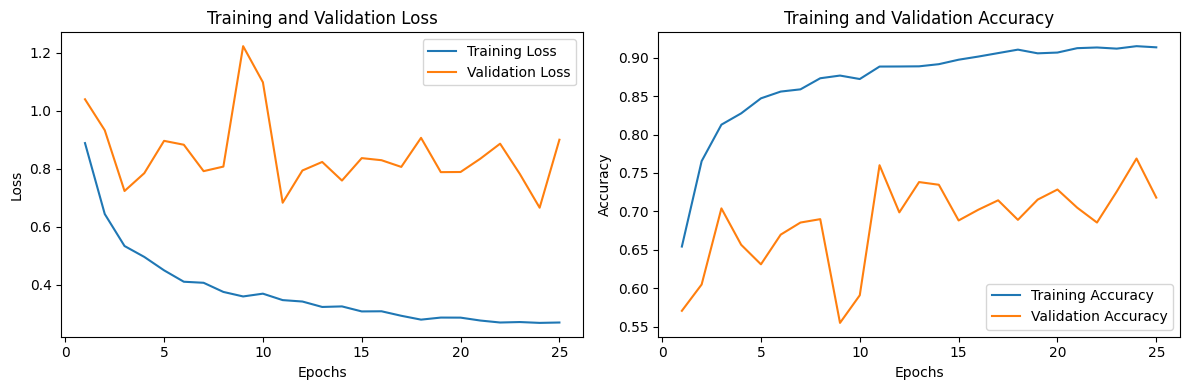

In [ ]:
history = {
    'loss': [0.8890, 0.6445, 0.5343, 0.4967, 0.4505, 0.4112, 0.4076, 0.3761, 0.3605, 0.3701, 0.3479, 0.3430, 0.3243, 0.3262, 0.3089, 0.3094, 0.2939, 0.2806, 0.2877, 0.2875, 0.2775, 0.2707, 0.2723, 0.2694, 0.2707],
    'accuracy': [0.6544, 0.7654, 0.8128, 0.8275, 0.8470, 0.8558, 0.8587, 0.8731, 0.8766, 0.8721, 0.8883, 0.8884, 0.8886, 0.8914, 0.8972, 0.9013, 0.9058, 0.9103, 0.9055, 0.9065, 0.9122, 0.9131, 0.9116, 0.9148, 0.9133],
    'val_loss': [1.0400, 0.9332, 0.7239, 0.7853, 0.8967, 0.8833, 0.7923, 0.8080, 1.2230, 1.0986, 0.6835, 0.7946, 0.8240, 0.7599, 0.8372, 0.8300, 0.8069, 0.9071, 0.7889, 0.7894, 0.8352, 0.8869, 0.7824, 0.6663, 0.9006],
    'val_accuracy': [0.5709, 0.6051, 0.7040, 0.6567, 0.6313, 0.6699, 0.6856, 0.6900, 0.5552, 0.5911, 0.7601, 0.6988, 0.7382, 0.7347, 0.6883, 0.7023, 0.7145, 0.6891, 0.7154, 0.7285, 0.7049, 0.6856, 0.7259, 0.7688, 0.7180]
}

epochs = range(1, len(history['loss']) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation


In [ ]:
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [ ]:
model_resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/498models/resnet.h5')
model_vgg16 = tf.keras.models.load_model('/content/drive/MyDrive/498models/vgg.h5')
model_mobilenetv2 = tf.keras.models.load_model('/content/drive/MyDrive/498models/MobileNetV2.h5')
model_inceptionv3 = tf.keras.models.load_model('/content/drive/MyDrive/InceptionV3.h5')


In [ ]:
models = {'ResNet50': model_resnet50, 'VGG16':model_vgg16, 'MobileNetv2':model_mobilenetv2, 'Inceptionv3':model_inceptionv3}

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Evaluate models
for model_name, model in models.items():
    # Test the model on the test set
    test_results = model.evaluate(test_generator)
    print(f"\n{model_name.capitalize()} Test Results:")
    print("Test Loss:", test_results[0])
    print("Test Accuracy:", test_results[1])

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1.0 / 255
)

39/39 [==============================] - 10s 238ms/step - loss: 0.6929 - accuracy: 0.7317

Resnet50 Test Results:
Test Loss: 0.6929070949554443
Test Accuracy: 0.731726884841919
39/39 [==============================] - 8s 212ms/step - loss: 0.2202 - accuracy: 0.9357

Vgg16 Test Results:
Test Loss: 0.220185324549675
Test Accuracy: 0.935742974281311
39/39 [==============================] - 10s 246ms/step - loss: 0.1870 - accuracy: 0.9558

Mobilenetv2 Test Results:
Test Loss: 0.18698883056640625
Test Accuracy: 0.9558233022689819
39/39 [==============================] - 8s 194ms/step - loss: 0.2326 - accuracy: 0.9293

Inceptionv3 Test Results:
Test Loss: 0.23263435065746307
Test Accuracy: 0.9293172955513


In [ ]:
for model_name, model in models.items():
  # Make predictions on the test set
    predictions = model.predict(test_generator2)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    acc = accuracy_score(true_labels, predicted_labels)
    print("\nAccuracy:", acc)
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)

39/39 [==============================] - 11s 290ms/step

Accuracy: 0.7317269076305221

Confusion Matrix:
[[337  15   2  17]
 [ 12 416   0  80]
 [ 70  40  21   7]
 [ 53  38   0 137]]
39/39 [==============================] - 8s 215ms/step

Accuracy: 0.9357429718875502

Confusion Matrix:
[[360   1   0  10]
 [ 10 491   0   7]
 [ 27  11 100   0]
 [  9   5   0 214]]
39/39 [==============================] - 7s 184ms/step

Accuracy: 0.9558232931726908

Confusion Matrix:
[[360   0  11   0]
 [  2 505   1   0]
 [  5   4 129   0]
 [ 23   9   0 196]]
39/39 [==============================] - 9s 234ms/step

Accuracy: 0.9293172690763052

Confusion Matrix:
[[363   2   6   0]
 [  9 472   6  21]
 [ 23  13 102   0]
 [  3   4   1 220]]


39/39 [==============================] - 8s 195ms/step - loss: 0.6929 - accuracy: 0.7317

Resnet50 Test Results:
Test Loss: 0.69290691614151
Test Accuracy: 0.731726884841919
39/39 [==============================] - 9s 234ms/step

Accuracy: 0.7317269076305221

Confusion Matrix:
[[337  15   2  17]
 [ 12 416   0  80]
 [ 70  40  21   7]
 [ 53  38   0 137]]

Class 1:
Precision: 0.7139830508474576
Recall: 0.9083557951482479
F1 Score: 0.7995255041518387
AUC-ROC Score: 0.9085167120824736

Class 2:
Precision: 0.8172888015717092
Recall: 0.8188976377952756
F1 Score: 0.8180924287118976
AUC-ROC Score: 0.9085167120824736

Class 3:
Precision: 0.9130434782608695
Recall: 0.15217391304347827
F1 Score: 0.26086956521739135
AUC-ROC Score: 0.9085167120824736

Class 4:
Precision: 0.5684647302904564
Recall: 0.6008771929824561
F1 Score: 0.5842217484008528
AUC-ROC Score: 0.9085167120824736


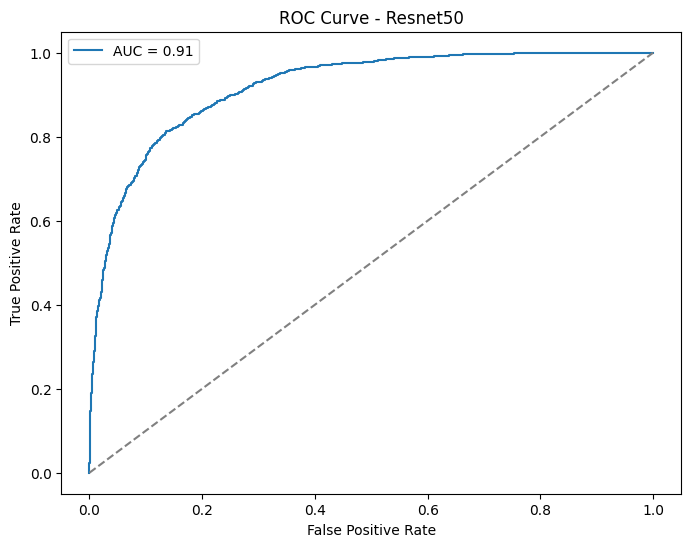

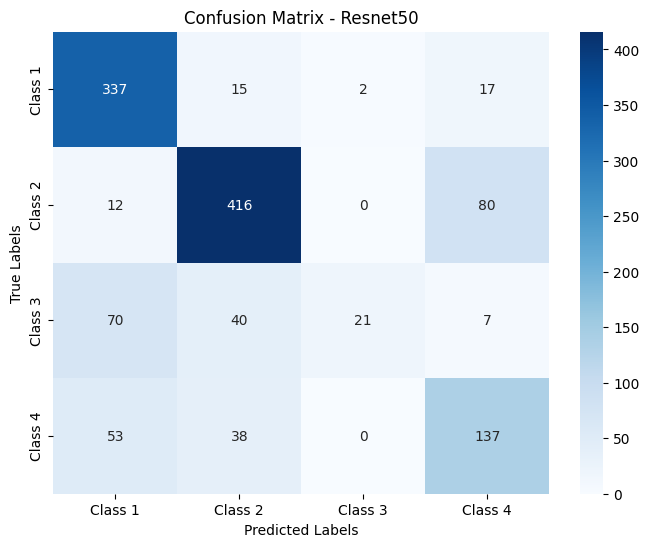

39/39 [==============================] - 8s 199ms/step - loss: 0.2202 - accuracy: 0.9357

Vgg16 Test Results:
Test Loss: 0.22018535435199738
Test Accuracy: 0.935742974281311
39/39 [==============================] - 9s 228ms/step

Accuracy: 0.9357429718875502

Confusion Matrix:
[[360   1   0  10]
 [ 10 491   0   7]
 [ 27  11 100   0]
 [  9   5   0 214]]

Class 1:
Precision: 0.8866995073891626
Recall: 0.9703504043126685
F1 Score: 0.9266409266409267
AUC-ROC Score: 0.9924463810788142

Class 2:
Precision: 0.9665354330708661
Recall: 0.9665354330708661
F1 Score: 0.9665354330708661
AUC-ROC Score: 0.9924463810788142

Class 3:
Precision: 1.0
Recall: 0.7246376811594203
F1 Score: 0.8403361344537814
AUC-ROC Score: 0.9924463810788142

Class 4:
Precision: 0.9264069264069265
Recall: 0.9385964912280702
F1 Score: 0.9324618736383443
AUC-ROC Score: 0.9924463810788142


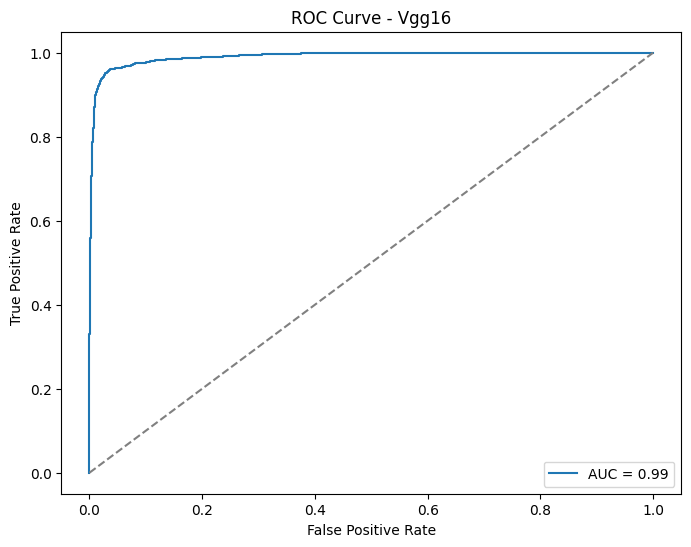

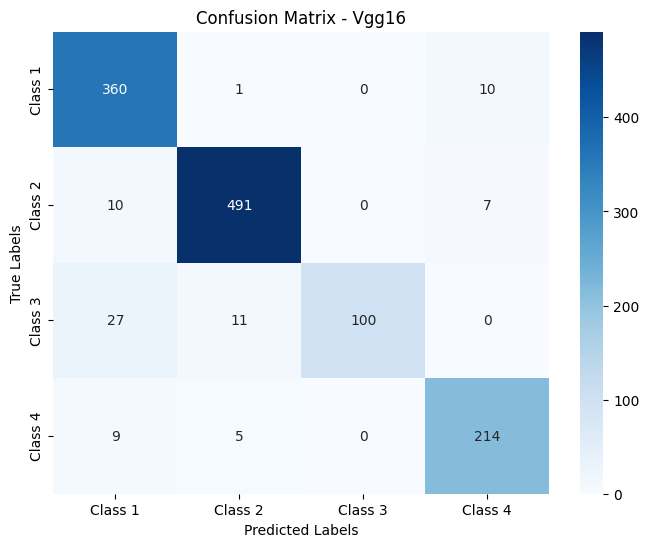

39/39 [==============================] - 8s 196ms/step - loss: 0.1870 - accuracy: 0.9558

Mobilenetv2 Test Results:
Test Loss: 0.18698883056640625
Test Accuracy: 0.9558233022689819
39/39 [==============================] - 8s 214ms/step

Accuracy: 0.9558232931726908

Confusion Matrix:
[[360   0  11   0]
 [  2 505   1   0]
 [  5   4 129   0]
 [ 23   9   0 196]]

Class 1:
Precision: 0.9230769230769231
Recall: 0.9703504043126685
F1 Score: 0.9461235216819973
AUC-ROC Score: 0.9943224300943617

Class 2:
Precision: 0.974903474903475
Recall: 0.9940944881889764
F1 Score: 0.9844054580896686
AUC-ROC Score: 0.9943224300943617

Class 3:
Precision: 0.9148936170212766
Recall: 0.9347826086956522
F1 Score: 0.924731182795699
AUC-ROC Score: 0.9943224300943617

Class 4:
Precision: 1.0
Recall: 0.8596491228070176
F1 Score: 0.9245283018867925
AUC-ROC Score: 0.9943224300943617


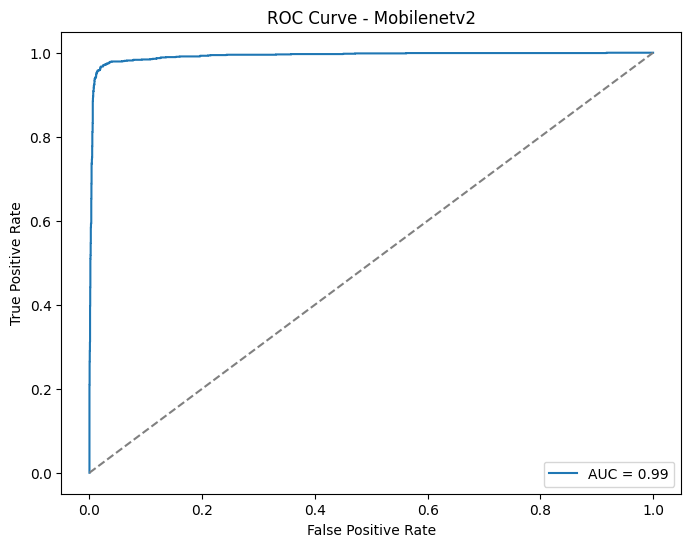

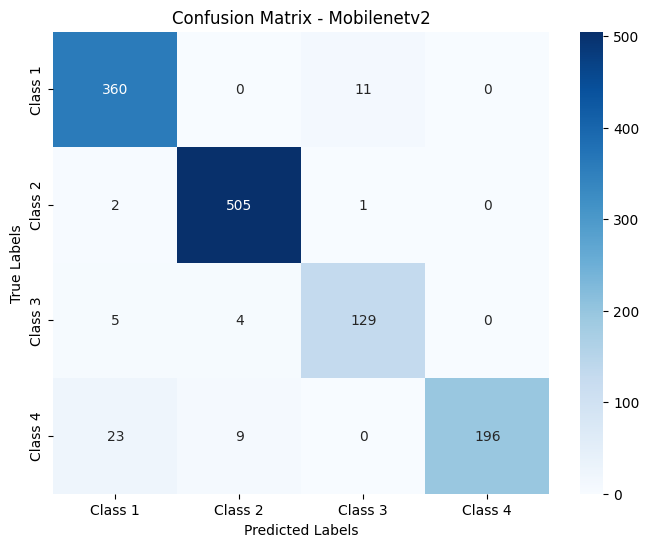

39/39 [==============================] - 8s 206ms/step - loss: 0.2326 - accuracy: 0.9293

Inceptionv3 Test Results:
Test Loss: 0.23263660073280334
Test Accuracy: 0.9293172955513
39/39 [==============================] - 8s 193ms/step

Accuracy: 0.9293172690763052

Confusion Matrix:
[[363   2   6   0]
 [  9 472   6  21]
 [ 23  13 102   0]
 [  3   4   1 220]]

Class 1:
Precision: 0.9120603015075377
Recall: 0.9784366576819407
F1 Score: 0.9440832249674903
AUC-ROC Score: 0.9894939159736515

Class 2:
Precision: 0.9613034623217923
Recall: 0.9291338582677166
F1 Score: 0.944944944944945
AUC-ROC Score: 0.9894939159736515

Class 3:
Precision: 0.8869565217391304
Recall: 0.7391304347826086
F1 Score: 0.8063241106719368
AUC-ROC Score: 0.9894939159736515

Class 4:
Precision: 0.9128630705394191
Recall: 0.9649122807017544
F1 Score: 0.9381663113006395
AUC-ROC Score: 0.9894939159736515


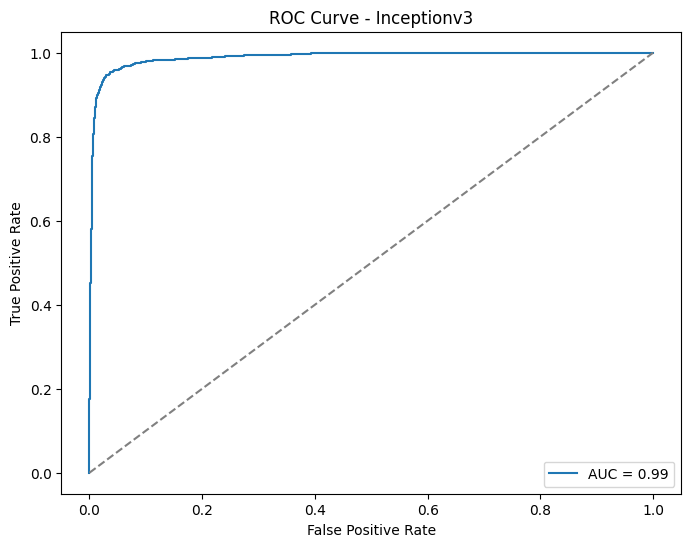

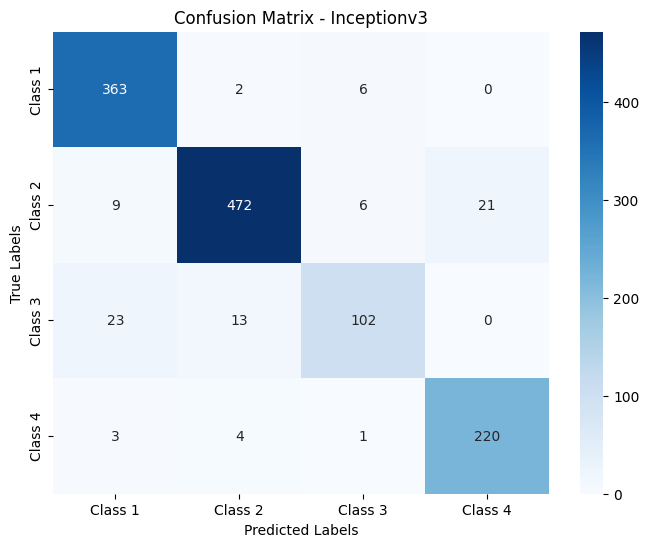

In [ ]:
num_classes = 4
# Evaluate models
for model_name, model in models.items():
    # Test the model on the test set
    test_results = model.evaluate(test_generator)
    print(f"\n{model_name.capitalize()} Test Results:")
    print("Test Loss:", test_results[0])
    print("Test Accuracy:", test_results[1])

    # Make predictions on the test set
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes

    # Calculate additional metrics
    acc = accuracy_score(true_labels, predicted_labels)
    print("\nAccuracy:", acc)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)

    # Calculate and print precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)
    auc_roc = roc_auc_score(tf.keras.utils.to_categorical(true_labels), predictions, multi_class='ovr')

    for i in range(len(precision)):
        print(f"\nClass {i + 1}:")
        print(f"Precision: {precision[i]}")
        print(f"Recall: {recall[i]}")
        print(f"F1 Score: {f1[i]}")
        print("AUC-ROC Score:", auc_roc)
    # Calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(tf.keras.utils.to_categorical(true_labels).ravel(), predictions.ravel())
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name.capitalize()}')
    plt.legend()
    plt.show()
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i+1}' for i in range(cm.shape[0])], yticklabels=[f'Class {i+1}' for i in range(cm.shape[0])])
    plt.title(f'Confusion Matrix - {model_name.capitalize()}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
class_names = list(test_generator.class_indices.keys())
class_names

['Cyst', 'Normal', 'Stone', 'Tumor']